In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import os
import numpy as np
import pandas as pd

In [33]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [34]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [36]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [38]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [40]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [41]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [43]:
#find column names for tables
inspector = inspect(engine)
measurement_col = inspector.get_columns('measurement')
print("table: 'mesurement' info: ")
for c in measurement_col:
    print(c['name'], c["type"])

print("------------------------------------------")
station_col = inspector.get_columns('station')
print("table: 'station' info: ")
for c in station_col:
    print(c['name'], c["type"])

table: 'mesurement' info: 
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
------------------------------------------
table: 'station' info: 
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

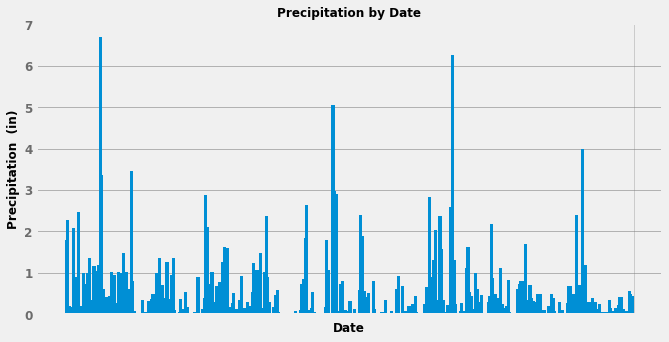

In [55]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data_prcp = session.query(Measurement.date,Measurement.prcp).\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').\
                    order_by(Measurement.date).all()

# Load data to a dataframe
prcp_df = pd.DataFrame(data_prcp, columns=['Date', 'Precipitation'])
# Sort dataframe by date
prcp_df = prcp_df.sort_values(by='Date', ascending=True)
#precipitation_df = precipitation_df.dropna()

# For setting up the index
# precipitation_df.set_index('Date', inplace=True)

# Resize the plot
plt.figure(figsize=(10,5));

# Plot the precipitation
plt.bar(prcp_df["Date"], prcp_df["Precipitation"], 
        align='center', width=2);

# Add labels and Title
plt.xlabel('Date',fontweight="bold", fontsize=12);
plt.ylabel('Precipitation  (in)',fontweight="bold", fontsize=12);
plt.title('Precipitation by Date' ,fontweight="bold", fontsize=12);

# Add Grids
plt.grid(b=bool, which='major', axis='y', color='grey',  alpha=0.55);

# Add ticks
plt.xticks("", rotation=90, fontweight="bold", alpha=0.55);
plt.yticks(rotation=0, fontweight="bold", alpha=0.55, fontsize=12)

# Save Plot
plt.savefig('Images/Plot01_Precipitation.png',bbox_inches='tight')
#Show the Plot
plt.show()

In [45]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# precipitation_df.set_index('Date', inplace=True)
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [46]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.id)).all()

[(9)]

In [47]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.station, func.count(Station.id)).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Station.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [48]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(Measurement.station,  func.min(Measurement.tobs), 
              func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").\
    group_by(Measurement.station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

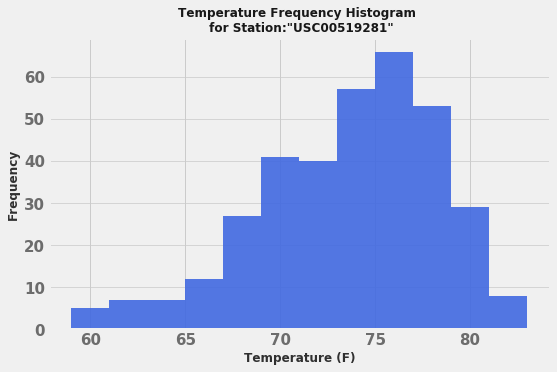

In [49]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.date,  Measurement.tobs).\
                    filter(Measurement.station == "USC00519281").\
                    filter(func.strftime("%Y-%m-%d", Measurement.date) >= '2016-08-23').all()

# Temperature dataframe cleanning process
temp_df = pd.DataFrame(temp, columns=['Date', 'Temperature'])
temp_df = temp_df.sort_values(by='Date', ascending=True)
temp_df.set_index('Date', inplace=True)

# Resize Plot
plt.figure(figsize=[8,5]);

# Define Histogram paramaters
n, bins, patches = plt.hist(x=temp_df["Temperature"], bins=12, 
                           color='royalblue',alpha=0.9);
# Labeling, tickers and grids
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Temperature (F)',fontweight="bold", alpha=0.8, fontsize=12)
plt.ylabel('Frequency',fontweight="bold", alpha=0.8, fontsize=12);
plt.xticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.yticks(fontsize=15, fontweight="bold", alpha=0.55);
plt.title('Temperature Frequency Histogram \n for Station:"USC00519281"',
          fontweight="bold", alpha=0.9, fontsize=12);

# Save Plot
plt.savefig('Images/Plot02_Temp_by_frequency.png')

#Show the Plot
plt.show()


In [50]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Vacation Dates
initial_vac_date = "2016-12-01"
final_vac_date = "2016-12-16"

# Previous Year Dates
initial_prev_year_date = "2015-12-01"
final_prev_year_date = "2015-12-16"

# Max, min and average calculation
min_vac_temp = calc_temps(initial_prev_year_date, final_prev_year_date)[0][0]
avg_vac_temp = calc_temps(initial_prev_year_date, final_prev_year_date)[0][1]
max_vac_temp = calc_temps(initial_prev_year_date, final_prev_year_date)[0][2]

print(min_vac_temp, avg_vac_temp, max_vac_temp)

65.0 73.41836734693878 82.0


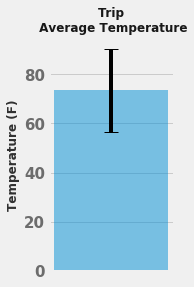

In [52]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

error_prev_year = max_vac_temp-min_vac_temp

# Resize Plot
plt.figure(figsize=[2,4]);

# Define Bar and Error paramaters
plt.bar(1, avg_vac_temp, yerr=error_prev_year, align='center', alpha=0.5, 
        ecolor='black', capsize=7)

# Labeling the plot
plt.ylabel('Temperature (F)',fontweight="bold", alpha=0.8, fontsize=12)
plt.xticks(fontsize=15, fontweight="bold", alpha=0.55)
plt.yticks(fontsize=15, fontweight="bold", alpha=0.55)
plt.title('Trip\n Average Temperature',
          fontweight="bold", alpha=0.9, fontsize=12)
plt.grid(b=None, which='major', axis='x')

plt.tick_params(
    axis='x',  
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 

# Save Plot
plt.savefig('Images/Plot03_Trip_Avg_Temp.png', bbox_inches='tight')

#Show the Plot
plt.show()

In [53]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.station,  Station.name, Station.latitude, Station.longitude, Station.elevation).\
   filter(Station.station == Measurement.station).\
       filter(Measurement.date >= initial_prev_year_date).filter(Measurement.date <= final_vac_date).\
           group_by(Measurement.station).\
               order_by(Measurement.prcp.desc()).all()

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [54]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]